# Data Cleaning

In [136]:
%pip install alerce

You should consider upgrading via the 'c:\Users\esteban ez\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [137]:
#install libraries

%pip install psycopg2-binary

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\esteban ez\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


### Imports

In [138]:
import psycopg2
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u
from astropy import coordinates
from astropy.time import Time
from datetime import datetime


from IPython.display import HTML
from ipywidgets import Layout, Box, widgets
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.cm import viridis
from alerce.core import Alerce

In [139]:
client = Alerce()

In [140]:
import requests
url = "https://raw.githubusercontent.com/alercebroker/usecases/master/alercereaduser_v4.json"
params = requests.get(url).json()['params']

In [141]:
conn = psycopg2.connect(dbname=params['dbname'], user=params['user'], host=params['host'], password=params['password'])

In [142]:
query = """
SELECT table_name  FROM information_schema.tables
WHERE table_schema='alerce'
ORDER BY table_name;
"""
tables = pd.read_sql_query(query, conn)
tables.sort_values(by="table_name")

c:\Users\esteban ez\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,table_name
0,allwise
1,dataquality
2,detection
3,feature
4,feature_version
5,gaia_ztf
6,lc_classifier
7,lc_classifier_periodic
8,lc_classifier_stochastic
9,lc_classifier_top


In [143]:
alltabs = []
for tab in sorted(tables.table_name):
    cols = pd.DataFrame()
    query = "select column_name, data_type from information_schema.columns where table_name = '%s';" % tab
    results = pd.read_sql_query(query, conn)
    results["table"] = tab
    alltabs.append(results)
dftab = pd.concat(alltabs)
pd.options.display.max_rows = 999
display(dftab[["table", "column_name", "data_type"]])
pd.options.display.max_rows = 101

c:\Users\esteban ez\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
c:\Users\esteban ez\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
c:\Users\esteban ez\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
c:\Users\esteban ez\AppData\Local\Programs\Python\Python310\lib\

,table,column_name,data_type
0,allwise,k_msig_2mass,double precision
1,allwise,ra,double precision
2,allwise,dec,double precision
3,allwise,w1mpro,double precision
4,allwise,w2mpro,double precision
5,allwise,w3mpro,double precision
6,allwise,w4mpro,double precision
7,allwise,w1sigmpro,double precision
8,allwise,w2sigmpro,double precision
9,allwise,w3sigmpro,double precision


In [144]:
mjd_first = Time("2021-03-01T00:00:00", scale='utc').mjd
mjd_last = Time("2021-04-01T00:00:00", scale='utc').mjd

query='''
SELECT
object.oid, object.meanra, object.meandec, object.firstmjd,
object.ndet, probability.probability

FROM object
INNER JOIN probability
ON object.oid=probability.oid

WHERE 
object.firstMJD>%s
AND object.firstMJD<%s
AND object.ndet=1
AND probability.classifier_name='stamp_classifier'
AND probability.class_name='asteroid'
AND probability.probability>0.7
''' % (mjd_first, mjd_last)

ast = pd.read_sql_query(query, conn)
ast.set_index('oid', inplace=True)
print(ast.shape)
ast.head()

c:\Users\esteban ez\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


(106896, 5)


,meanra,meandec,firstmjd,ndet,probability
oid,,,,,
ZTF21aanqjqc,84.403597,10.469394,59274.147813,1,0.725208
ZTF21aanqpyv,154.226348,12.072717,59274.212454,1,0.710321
ZTF21aanqpxc,157.088644,15.424231,59274.212454,1,0.728637
ZTF21aanqpzu,156.451785,14.969416,59274.212454,1,0.705238
ZTF21aanqpwg,156.660014,10.679691,59274.212454,1,0.700072


In [145]:
query='''
SELECT *
FROM ss_ztf
WHERE 
oid in (%s)
AND ssdistnr >= 0
AND ssdistnr <= 5.0
ORDER BY oid
''' % ",".join(["'%s'" % oid for oid in ast.index])

ss = pd.read_sql_query(query, conn)
print(ss.shape)
ss.head()

c:\Users\esteban ez\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


(106387, 5)


,oid,candid,ssdistnr,ssmagnr,ssnamenr
0,ZTF18aaavzci,1549155913415015015,0.0,19.9,77314
1,ZTF18aaaxbqb,1549153564115015003,1.0,19.5,36263
2,ZTF18aaaxbuo,1547212622015015006,0.0,18.1,13289
3,ZTF18aabqfyb,1550307190015015012,0.0,19.8,349197
4,ZTF18aabwrag,1549239930415015008,0.0,20.0,175315


Text(0.5, 0, 'arcsec')

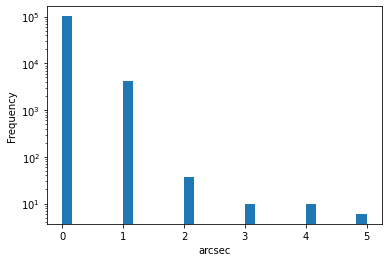

In [146]:
ax = ss.ssdistnr.plot.hist(bins=30, log=True)
ax.set_xlabel('arcsec')

Text(0.5, 0, 'Number of detections')

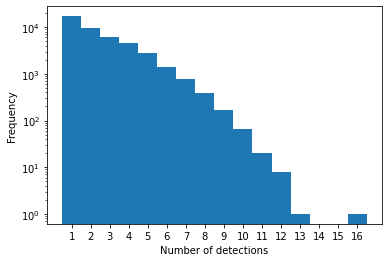

In [147]:
ndet = ss.groupby("ssnamenr").apply(lambda df: df.shape[0])
ax = ndet.plot.hist(log=True, bins=np.linspace(1,max(ndet)+1,max(ndet)+1)-.5)
ax.set_xticks(np.linspace(1,max(ndet),max(ndet)))
ax.set_xlabel('Number of detections')

c:\Users\esteban ez\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
c:\Users\esteban ez\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
c:\Users\esteban ez\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
c:\Users\esteban ez\AppData\Local\Programs\Python\Python310\lib\

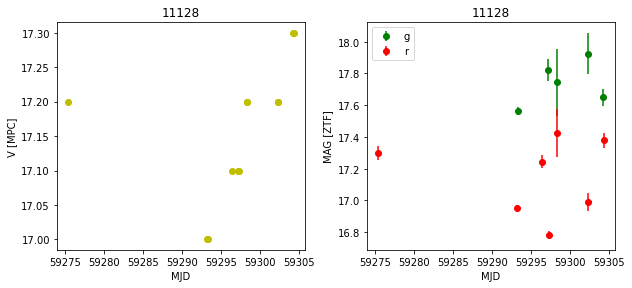

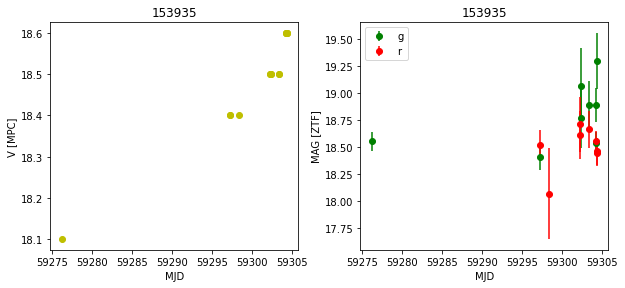

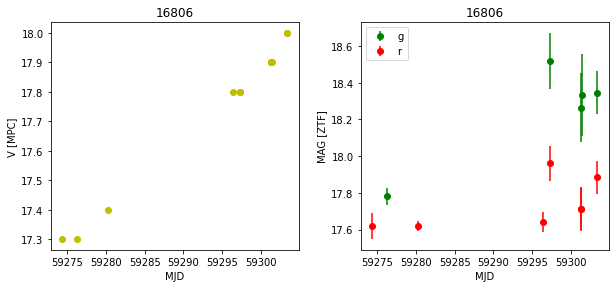

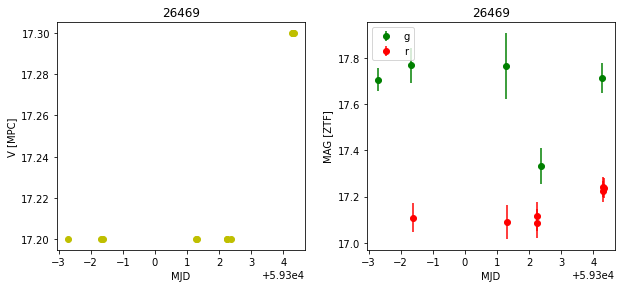

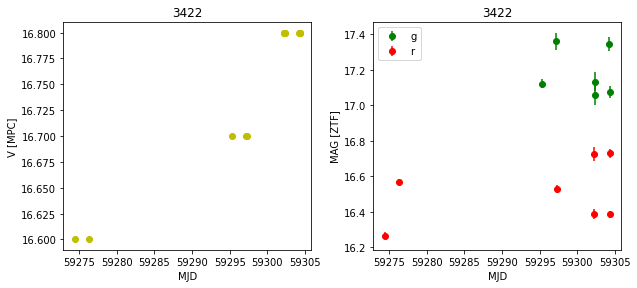

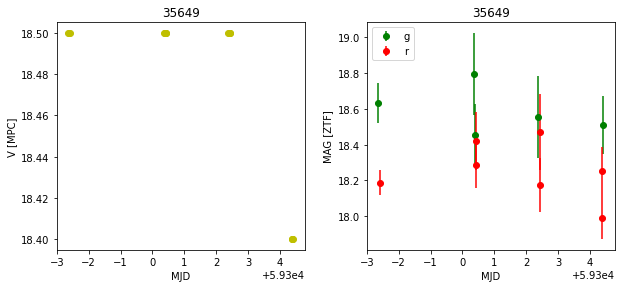

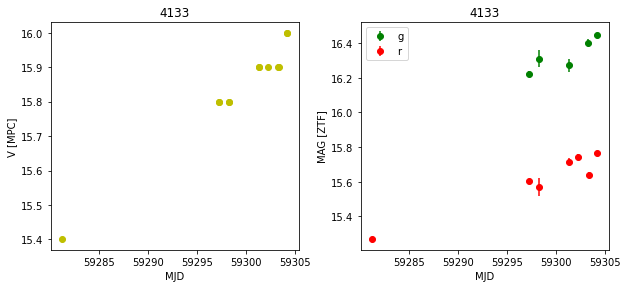

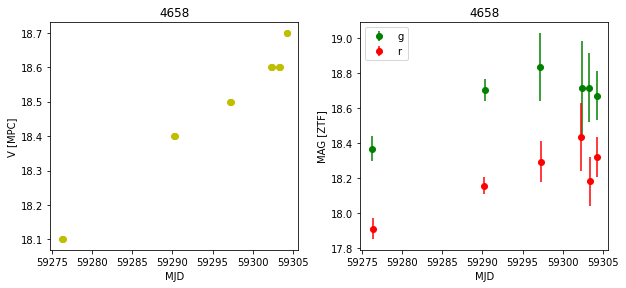

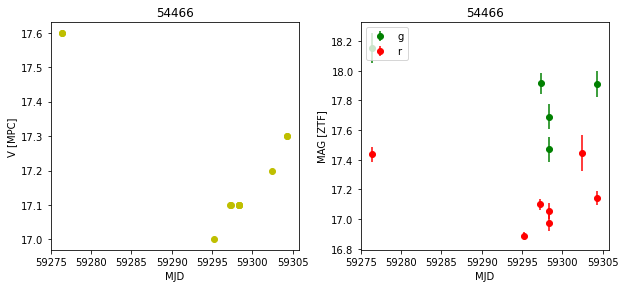

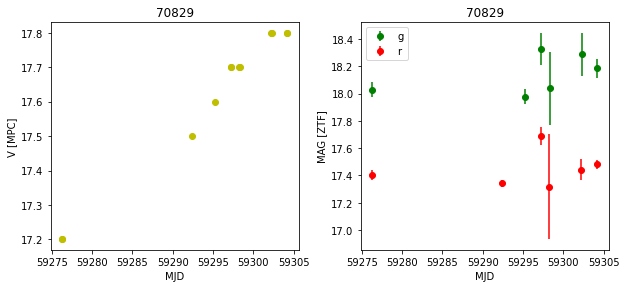

In [148]:
# Light curves predichas vs observadas en g y r

ndetmin = 12
for ssnamenr in ndet.loc[ndet>=ndetmin].index:
  oids = ss.loc[ss['ssnamenr']==ssnamenr].oid
  query='''
  SELECT oid, mjd, fid, magap, sigmagap, has_stamp
  FROM detection
  WHERE 
  oid in (%s)
  ORDER BY oid
  ''' % ",".join(["'%s'" % oid for oid in oids])

  dets = pd.read_sql_query(query, conn)
  Vmpc = ss.loc[ss.ssnamenr == ssnamenr].ssmagnr.values
  t = dets.mjd.values; mags = dets.magap.values; mags_err = dets.sigmagap.values
  filters = dets.fid.values; g = filters==1; r = filters==2
  fig, ax = plt.subplots(ncols=2, figsize=(10,4))
  fig.subplots_adjust(top=0.96, bottom=.17, hspace=0.05, wspace=0.25)

  ax[0].scatter(t, Vmpc, color='y')
  ax[0].set_title(ssnamenr); ax[0].set_xlabel("MJD"); ax[0].set_ylabel("V [MPC]")

  ax[1].errorbar(t[g], mags[g], yerr=mags_err[g], color='g', label='g', fmt='o')
  ax[1].errorbar(t[r], mags[r], yerr=mags_err[r], color='r', label='r', fmt='o')
  ax[1].set_title(ssnamenr); ax[1].set_xlabel("MJD"); ax[1].set_ylabel("MAG [ZTF]")
  ax[1].legend(loc="upper left")

c:\Users\esteban ez\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
c:\Users\esteban ez\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
c:\Users\esteban ez\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
c:\Users\esteban ez\AppData\Local\Programs\Python\Python310\lib\

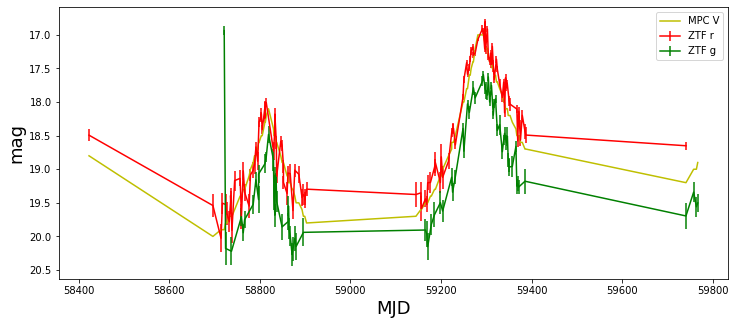

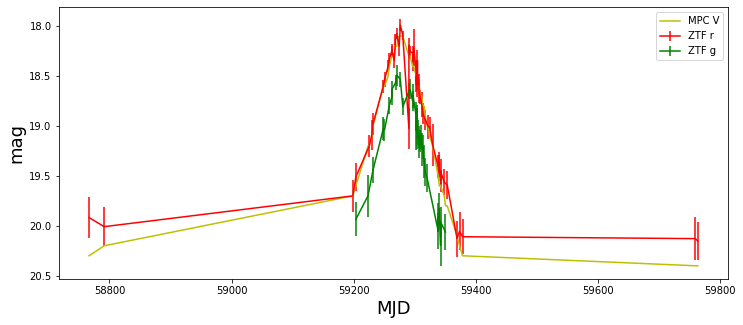

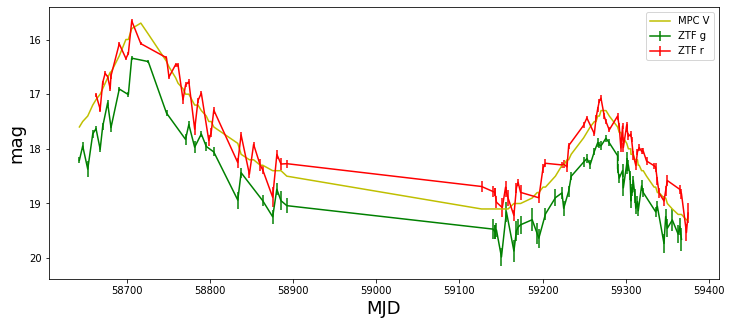

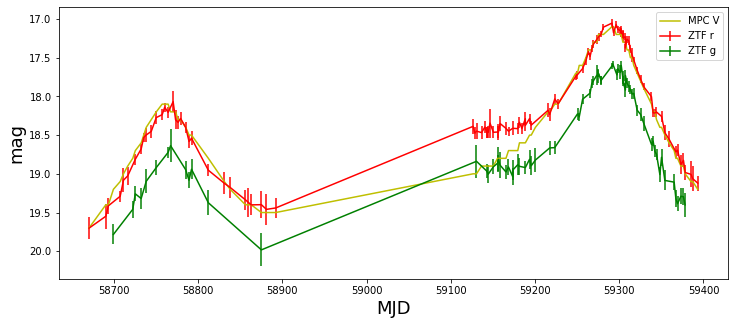

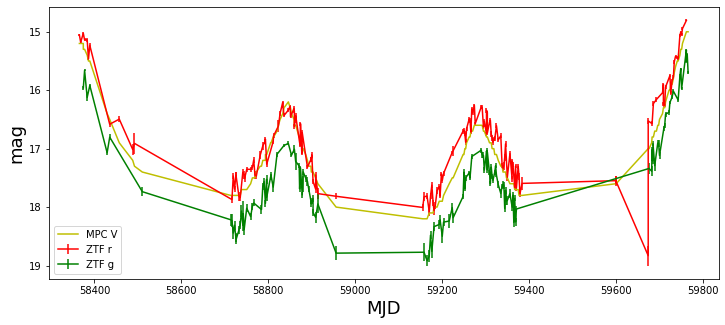

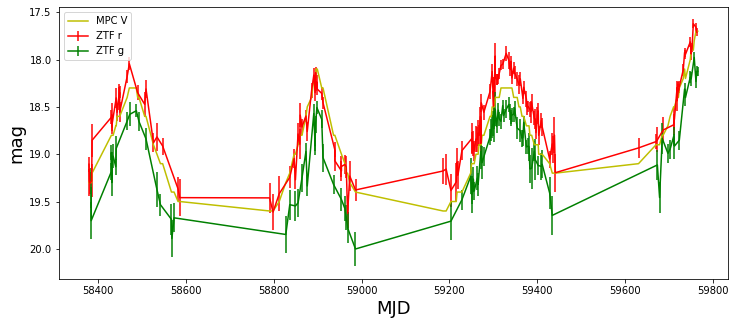

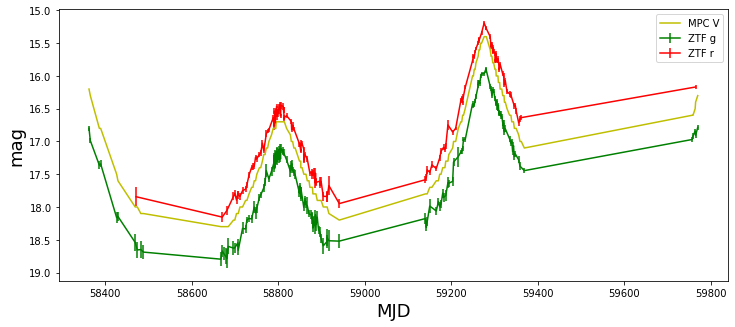

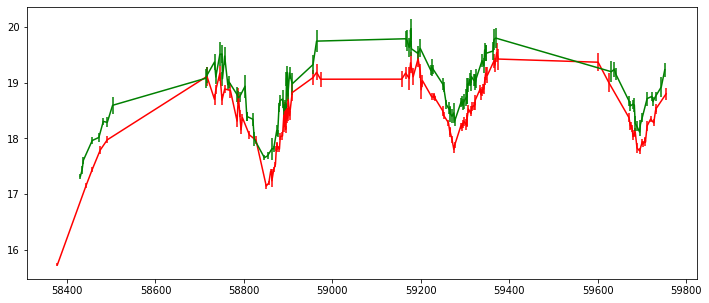

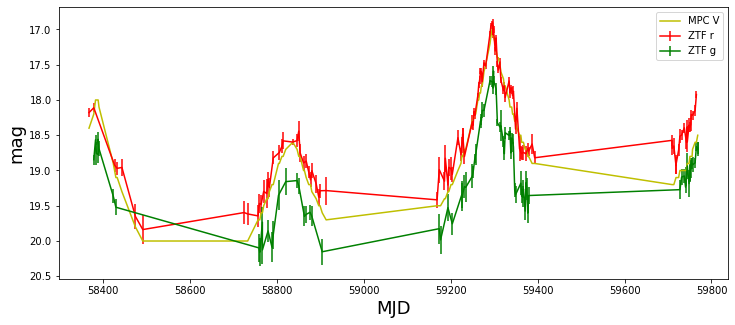

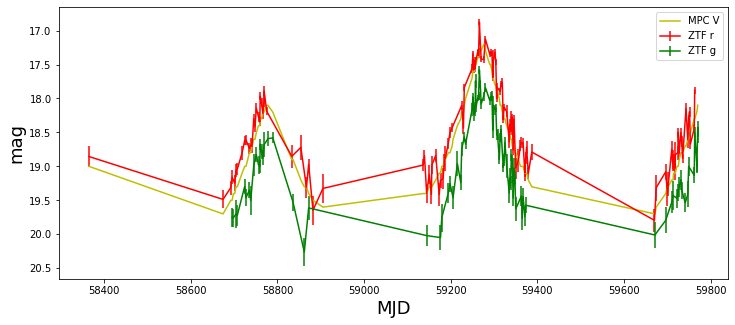

In [149]:
ndetmin = 12
for ssnamenr in ndet.loc[ndet>=ndetmin].index:
  oids = ss.loc[ss['ssnamenr']==ssnamenr].oid
  query='''
  SELECT *
  FROM ss_ztf
  WHERE 
  ssnamenr = '%s'
  ''' % ssnamenr

  selast = pd.read_sql_query(query, conn)
  selast.set_index("candid", inplace=True)
  query='''
  SELECT candid, mjd, fid, magpsf, sigmapsf
  FROM detection
  WHERE 
  candid in (%s)
  ''' % ",".join(["'%s'" % candid for candid in selast.index])

  selast_lc = pd.read_sql_query(query, conn)
  selast_lc.set_index("candid", inplace=True)
  colors = {1: 'g', 2: 'r'}
  fig, ax = plt.subplots(figsize=(12,5))
  for fid in selast_lc.fid.unique():
    mask = (selast_lc.fid == fid)
    ax.errorbar(selast_lc.loc[mask].mjd, selast_lc.loc[mask].magpsf, yerr=selast_lc.loc[mask].sigmapsf, c=colors[fid], label = "ZTF %s" % colors[fid])
  if len(selast_lc.mjd) == len(selast.loc[selast_lc.index].ssmagnr):
    ax.plot(selast_lc.mjd, selast.loc[selast_lc.index].ssmagnr, c='y', label='MPC V')
    ax.set_ylim(ax.get_ylim()[::-1])
    ax.set_xlabel("MJD", fontsize=18)
    ax.set_ylabel("mag", fontsize=18)
    ax.legend()

11128


c:\Users\esteban ez\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
c:\Users\esteban ez\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


153935


c:\Users\esteban ez\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
c:\Users\esteban ez\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
c:\Users\esteban ez\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


16806


c:\Users\esteban ez\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


26469


c:\Users\esteban ez\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
c:\Users\esteban ez\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


3422


c:\Users\esteban ez\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
c:\Users\esteban ez\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


35649


c:\Users\esteban ez\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
c:\Users\esteban ez\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


4133


c:\Users\esteban ez\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
c:\Users\esteban ez\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


54466


c:\Users\esteban ez\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
c:\Users\esteban ez\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


70829


c:\Users\esteban ez\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
c:\Users\esteban ez\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


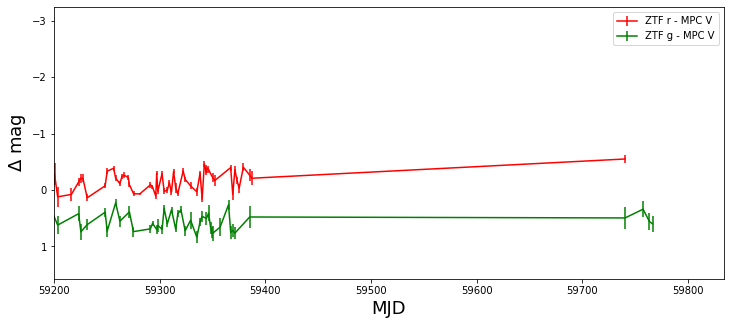

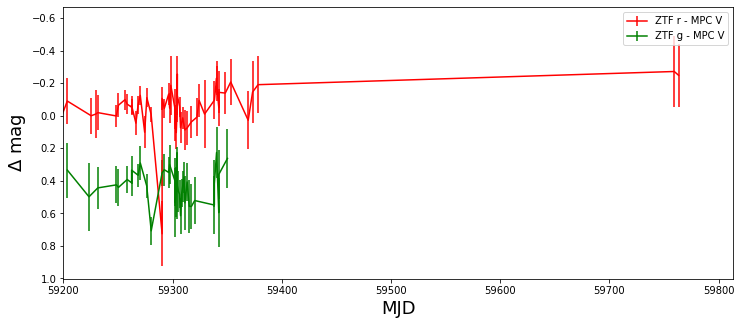

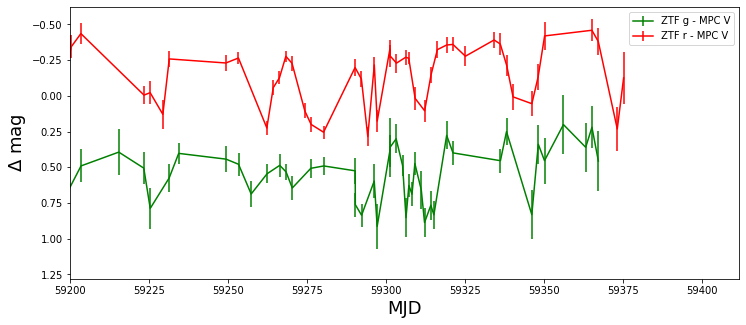

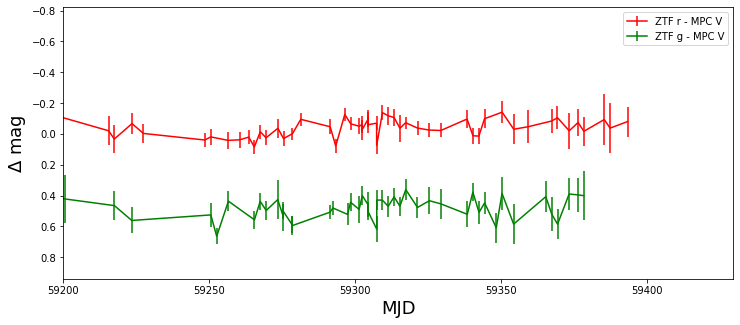

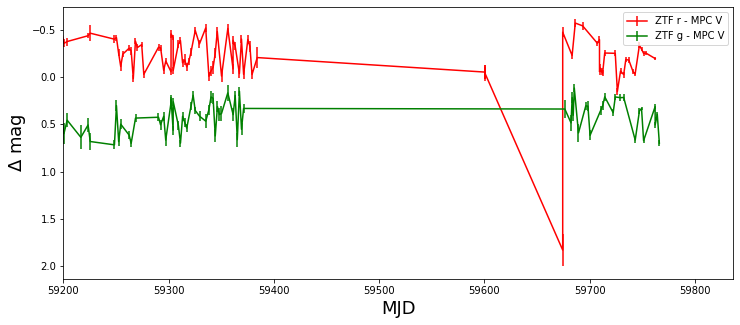

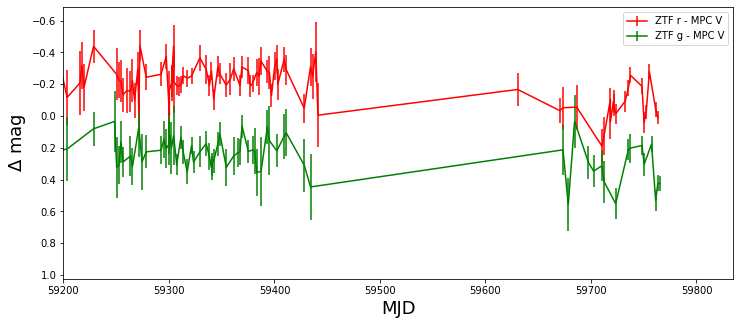

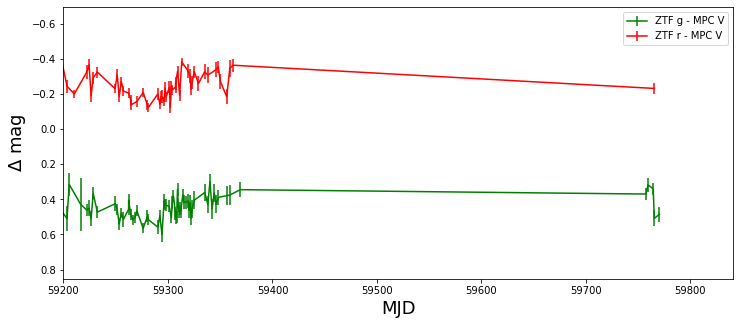

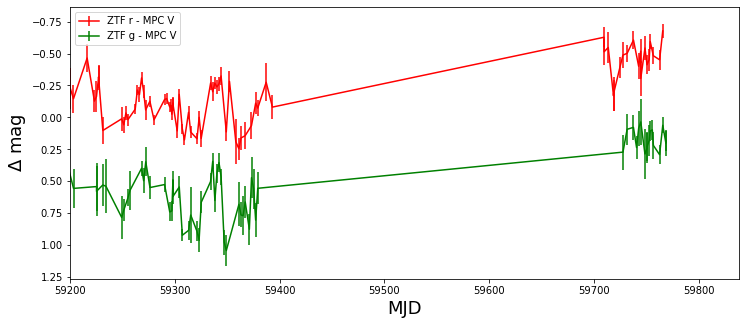

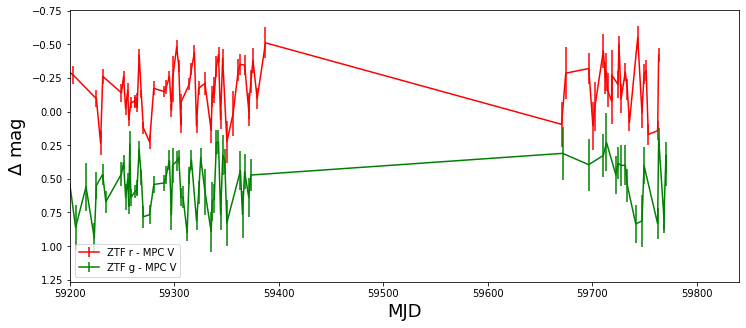

In [150]:
ndetmin = 12
ndet2 =ndet.drop(index= '4658')
for ssnamenr in ndet2.loc[ndet>=ndetmin].index:
  print(ssnamenr)
  oids = ss.loc[ss['ssnamenr']==ssnamenr].oid
  query='''
  SELECT *
  FROM ss_ztf
  WHERE 
  ssnamenr = '%s'
  ''' % ssnamenr

  selast = pd.read_sql_query(query, conn)
  selast.set_index("candid", inplace=True)
  query='''
  SELECT candid, mjd, fid, magpsf, sigmapsf
  FROM detection
  WHERE 
  candid in (%s)
  ''' % ",".join(["'%s'" % candid for candid in selast.index])

  selast_lc = pd.read_sql_query(query, conn)
  selast_lc.set_index("candid", inplace=True)
  colors = {1: 'g', 2: 'r'}
  fig, ax = plt.subplots(figsize=(12,5))
  for fid in selast_lc.fid.unique():
    mask = (selast_lc.fid == fid)
    ax.errorbar(selast_lc.loc[mask].mjd, selast_lc.loc[mask].magpsf - selast.loc[selast_lc.loc[mask].index].ssmagnr,
                yerr=selast_lc.loc[mask].sigmapsf, c=colors[fid], label='ZTF %s - MPC V' % colors[fid])
  if len(selast_lc.mjd) == len(selast.loc[selast_lc.index].ssmagnr):
    ax.set_ylim(ax.get_ylim()[::-1])
    ax.set_xlim(59200,ax.get_xlim()[1])
    ax.legend()
    ax.set_xlabel("MJD", fontsize=18)
    ax.set_ylabel(r"$\Delta$ mag", fontsize=18)

In [151]:
ndetmin = 10
X = []
Y = []
for ssnamenr in ndet.loc[ndet>=ndetmin].index:
  query='''
  SELECT *
  FROM ss_ztf
  WHERE 
  ssnamenr = '%s'
  ''' % ssnamenr

  selast = pd.read_sql_query(query, conn)
  selast.set_index("candid", inplace=True)
  query='''
  SELECT candid, mjd, fid, magpsf, sigmapsf
  FROM detection
  WHERE 
  candid in (%s)
  ''' % ",".join(["'%s'" % candid for candid in selast.index])

  selast_lc = pd.read_sql_query(query, conn)
  selast_lc.set_index("candid", inplace=True)
  for fid in selast_lc.fid.unique():
    mask = (selast_lc.fid == fid)

    if len(selast_lc.loc[mask].mjd) > 1 and len(selast_lc.loc[mask].mjd)==len(selast_lc.loc[mask].magpsf) and len(selast_lc.fid.unique())==2: 
      X.append(np.array(selast_lc.loc[mask].mjd).tolist())
      Y.append(np.array(selast_lc.loc[mask].magpsf).tolist())

    


c:\Users\esteban ez\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
c:\Users\esteban ez\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
c:\Users\esteban ez\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\io\sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
c:\Users\esteban ez\AppData\Local\Programs\Python\Python310\lib\

In [152]:
j=0
lens = []
while j < len(X):
    lens.append(len(X[j]))
    j=j+1

Xt = X
Yt = Y
X2 = []
Y2 = []


i=0
while i< len(Xt):

    if len(Xt[i][:150])<150:
        k = len(Xt[i])
        while k < 150:
            Xt[i].append((Xt[i][len(Xt[i])-1]))
            k = k+1    
    else:
        Xt[i]=(Xt[i][:150])
        i=i+1
        
i=0
while i< len(Yt):
    if len(Yt[i][:150])<150:
        k = len(Yt[i])
        while k < 150:
            Yt[i].append((Yt[i][len(Yt[i])-1]))
            k= k+1
    else:
        Yt[i]=(Yt[i][:150])
    i=i+1



In [153]:
j=0
Xt2 = Xt
Yt2 = Yt
while j < len(X):
    Xt2[j]=np.array(Xt[j])
    Yt2[j]=np.array(Yt[j])
    j=j+1
Yt2 = np.array(Yt2)
Yt2 = np.array(Yt2)

In [154]:
np.shape(Yt2)
np.shape(Xt2)

(180, 150)

In [155]:
j=0
Xt3 = []
Yt3 = []
while j < len(Yt)/2:
    Xt3.append(np.concatenate((Xt2[2*j], Xt2[2*j + 1] )))
    Yt3.append(np.concatenate((Yt2[2*j], Yt2[2*j + 1] )))
    j=j+1
Yt3 = np.array(Yt3)
Yt3 = np.array(Yt3)

In [156]:
j=0
M = []
while j < len(Yt3):
    M.append(np.concatenate((Xt3[j], Yt3[j])))
    j=j+1
M = np.array(M)


In [157]:
df = pd.DataFrame(M)
df

,0,1,2,3,4,5,6,7,8,9,...,590,591,592,593,594,595,596,597,598,599
0,58693.476482,58706.499803,58723.387188,58726.378912,58730.418623,58736.435347,58739.377593,58744.379444,58757.326181,58760.316065,...,20.415716,20.415716,20.415716,20.415716,20.415716,20.415716,20.415716,20.415716,20.415716,20.415716
1,58423.077905,58696.495810,58714.453773,58717.483125,58724.498542,58727.509271,58732.485035,58735.491319,58735.505880,58738.519815,...,19.501478,19.501478,19.501478,19.501478,19.501478,19.501478,19.501478,19.501478,19.501478,19.501478
2,58344.337407,58347.328958,58736.478854,58751.400139,58756.415706,58775.187454,58778.294988,58785.326215,58788.356354,58794.256262,...,19.485050,19.485050,19.485050,19.485050,19.485050,19.485050,19.485050,19.485050,19.485050,19.485050
3,58368.357488,58371.335868,58374.273715,58380.337326,58732.435602,58751.406701,58756.425810,58763.456724,58778.308530,58790.318345,...,19.090761,19.090761,19.090761,19.090761,19.090761,19.090761,19.090761,19.090761,19.090761,19.090761
4,58334.169201,58338.169630,58662.444306,58667.443125,58670.456482,58673.475602,58682.485718,58685.475498,58690.464815,58693.455231,...,18.526644,18.526644,18.526644,18.526644,18.526644,18.526644,18.526644,18.526644,18.526644,18.526644
5,58720.386308,58723.389028,58726.378912,58730.418623,58733.402384,58750.315417,58757.323831,58760.316065,58764.415428,58777.202546,...,20.234474,20.234474,20.234474,20.234474,20.234474,20.234474,20.234474,20.234474,20.234474,20.234474
6,58367.377477,58376.355324,58379.394352,58382.330938,58717.482674,58759.499850,58766.501377,58766.522025,58803.314572,58805.390787,...,19.859880,19.859880,19.859880,19.859880,19.859880,19.859880,19.859880,19.859880,19.859880,19.859880
7,58723.387188,58726.379826,58736.433507,58747.400590,58750.315417,58757.323831,58760.316065,58764.415428,58790.196759,58791.342720,...,20.356853,20.356853,20.356853,20.356853,20.356853,20.356853,20.356853,20.356853,20.356853,20.356853
8,58430.148079,58469.106065,58488.129074,58670.449259,58673.481401,58679.455706,58686.487292,58695.447812,58698.477975,58704.451724,...,18.668913,18.668913,18.668913,18.668913,18.668913,18.668913,18.668913,18.668913,18.668913,18.668913
9,58867.252384,58871.250289,58875.227986,59249.413403,59251.462338,59253.487500,59255.418403,59262.360671,59264.373866,59266.376655,...,20.206560,20.206560,20.206560,20.206560,20.206560,20.206560,20.206560,20.206560,20.206560,20.206560


In [158]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=3)
